In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *
from hossam.regression import *

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
import sys
sys.path.append("Y:\Python\Mega_IT")

from yjk_module.preprocessing import *
from yjk_module.ml_module import *

In [3]:
origin1 = pd.read_excel("./data/pima_indians_diabetes.xlsx")
origin1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df1 = origin1.copy()
df1[zero_features] = df1[zero_features].replace(0, np.nan)
df1_2 = my_replace_missing_value(df1)

# 결과확인
total_count = len(origin1)

for feature in zero_features:
    zero_count = origin1[origin1[feature] == 0][feature].count()
    print(
        "{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %".format(
            feature, zero_count, 100 * zero_count / total_count
        )
    )

print("---" * 30)

for feature in zero_features:
    zero_count = df1_2[df1_2[feature] == 0][feature].count()
    print(
        "{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %".format(
            feature, zero_count, 100 * zero_count / total_count
        )
    )

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %
------------------------------------------------------------------------------------------
Glucose 0 건수는 0, 퍼센트는 0.00 %
BloodPressure 0 건수는 0, 퍼센트는 0.00 %
SkinThickness 0 건수는 0, 퍼센트는 0.00 %
Insulin 0 건수는 0, 퍼센트는 0.00 %
BMI 0 건수는 0, 퍼센트는 0.00 %


In [5]:
x_train, x_test, y_train, y_test = my_train_test_split(df1_2, "Outcome", scalling=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


In [6]:
%%time

# RandomForest 분류기
estimator = RandomizedSearchCV(
    estimator=get_estimator(classname=RandomForestClassifier), 
    param_distributions=get_hyper_params(classname=RandomForestClassifier), 
    n_iter=get_max_iter(),
    n_jobs = 16,
    random_state=get_random_state(),
    cv=5
)

estimator.fit(x_train, y_train)
estimator

CPU times: total: 344 ms
Wall time: 3.59 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0,
                                                    verbose=False),
                   n_iter=1000, n_jobs=16,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'n_estimators': [10, 20, 50, 100]},
                   random_state=0)

In [7]:
result_df = pd.DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)

result_df

,n_estimators,max_features,max_depth,criterion,mean_test_score
53,20,log2,10.0,entropy,0.762228
38,50,sqrt,NaN,gini,0.759016
14,50,sqrt,20.0,gini,0.759016
26,50,sqrt,50.0,gini,0.759016
1,20,sqrt,10.0,gini,0.758990
...,...,...,...,...,...
76,10,log2,50.0,entropy,0.723137
64,10,log2,20.0,entropy,0.721511
61,20,sqrt,20.0,entropy,0.719885
85,20,sqrt,NaN,entropy,0.718259


+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.978827 |     0.818182 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.977064 |     0.686275 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |     0.963801 |     0.744681 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0127226 |     0.149533 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.987277 |     0.850467 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |     0.970387 |     0.714286 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.997525 |      0.84659 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--------------

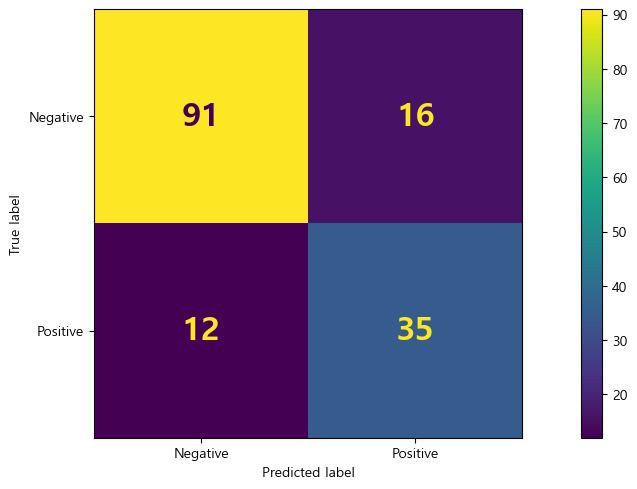

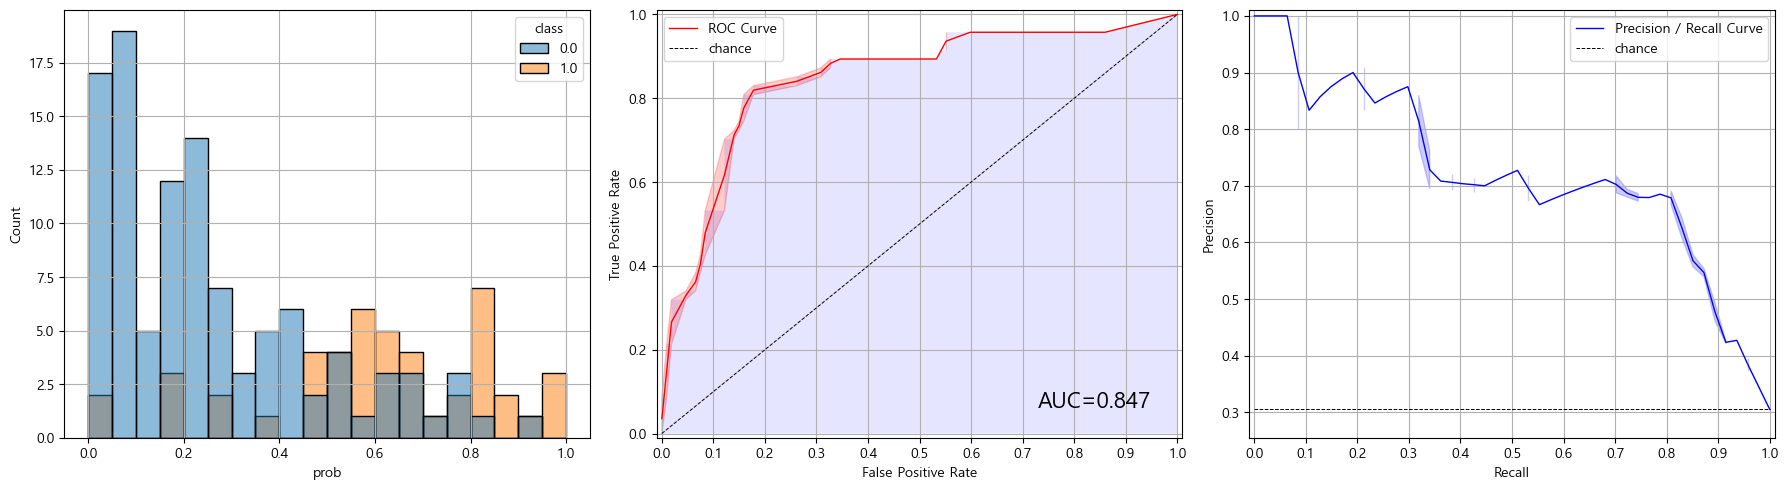

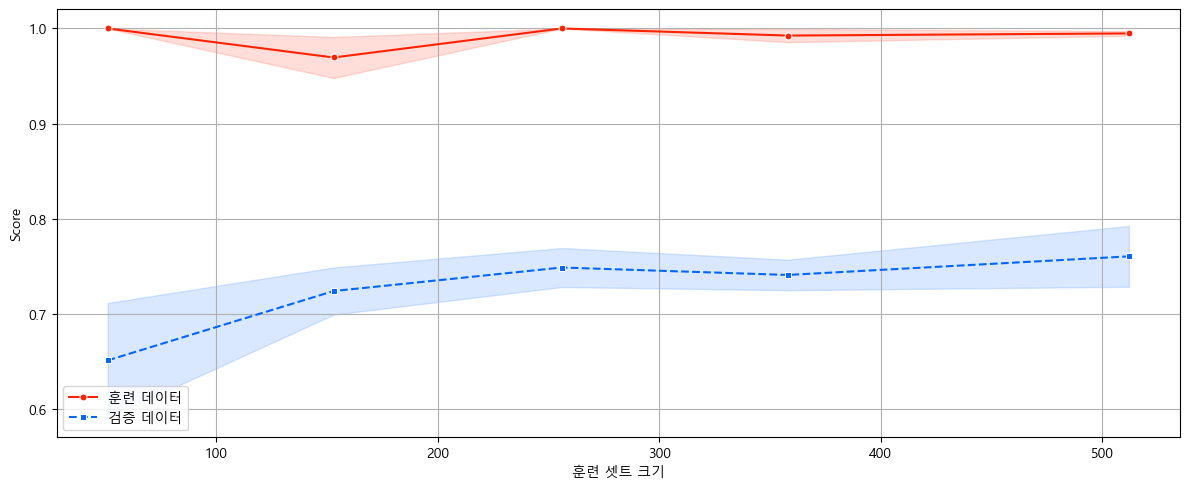

CPU times: total: 953 ms
Wall time: 26.7 s


In [8]:
%%time
my_classification_result(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

In [9]:
%%time
my_classification_report(
    estimator=estimator, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+
CPU times: total: 0 ns
Wall time: 3 ms


[교차검증 TOP5]
+----+----------------+----------------+-------------+-------------+-------------------+
|    |   n_estimators | max_features   |   max_depth | criterion   |   mean_test_score |
|----+----------------+----------------+-------------+-------------+-------------------|
|  0 |             50 | sqrt           |          50 | gini        |          0.759016 |
|  1 |            100 | log2           |          10 | entropy     |           0.75082 |
|  2 |             20 |                |          50 | entropy     |           0.75082 |
|  3 |             50 | log2           |          10 | entropy     |          0.747568 |
|  4 |             50 | sqrt           |          10 | gini        |          0.747554 |
+----+----------------+----------------+-------------+-------------+-------------------+

[Best Params]
{'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'gini'}

+-------------------+--------------+--------------+-------------------------------------

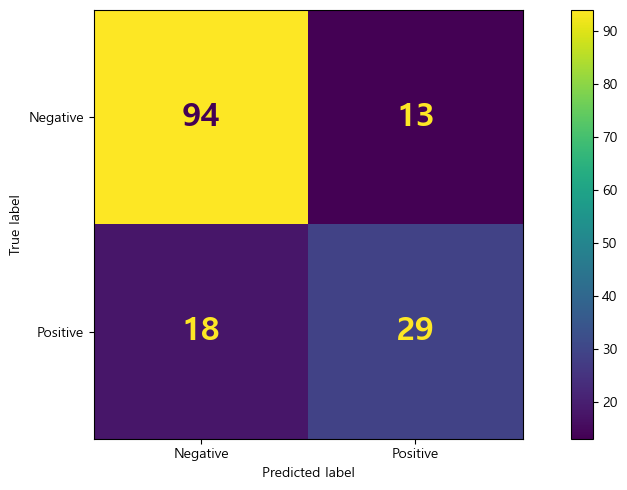

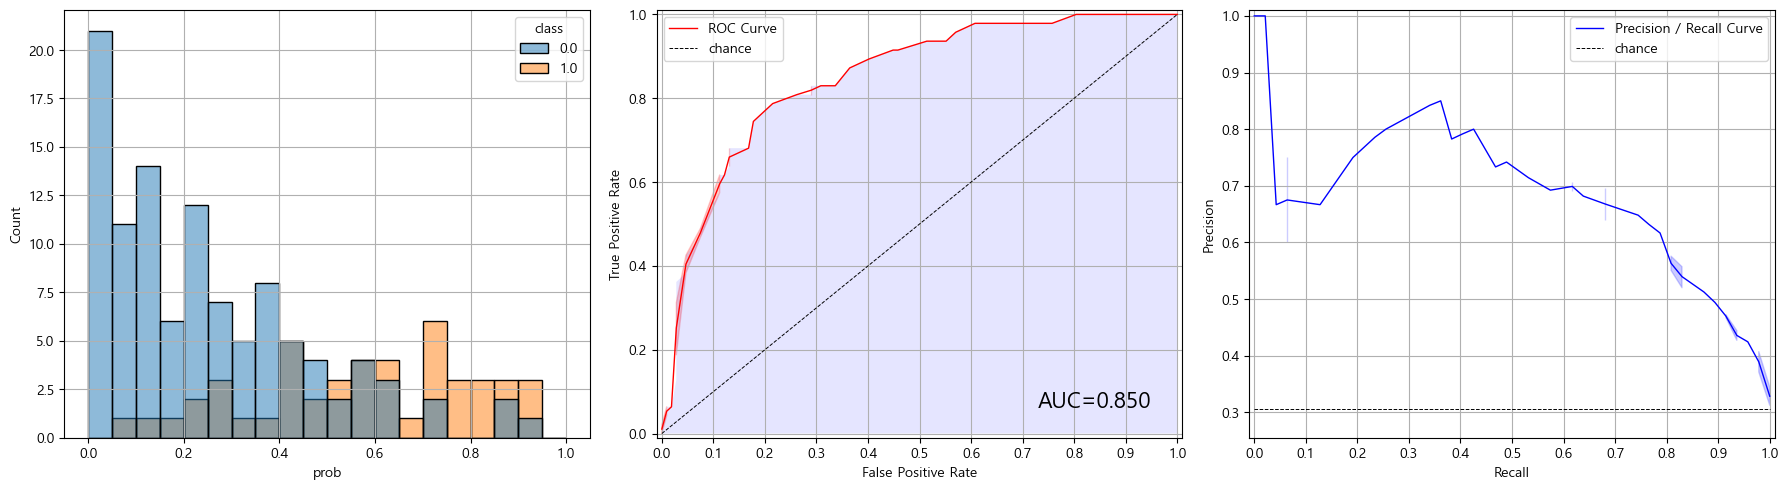

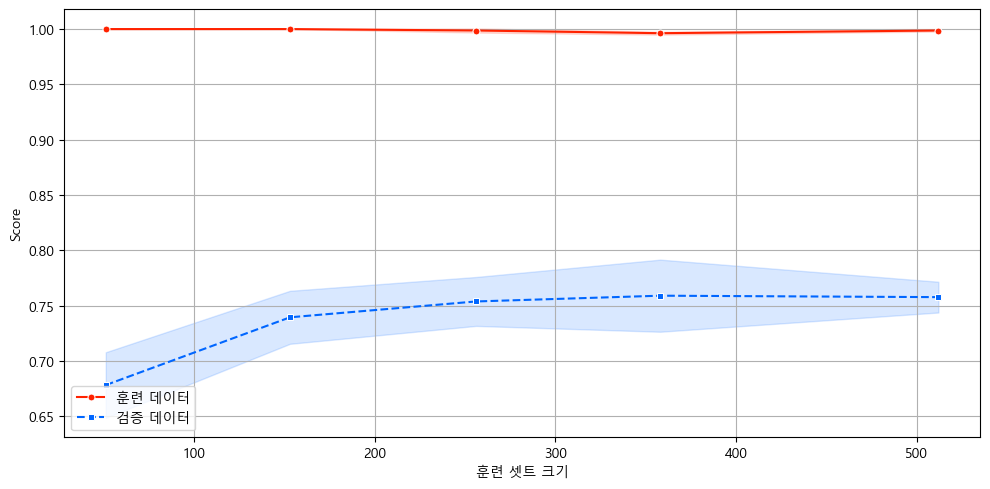

+----+------------+--------------------------+---------+
|    | 종속변수   | 독립변수                 |     VIF |
|----+------------+--------------------------+---------|
|  0 | Outcome    | Pregnancies              | 1.53706 |
|  1 | Outcome    | Glucose                  | 1.33393 |
|  2 | Outcome    | BloodPressure            | 1.25589 |
|  3 | Outcome    | SkinThickness            |  1.5504 |
|  4 | Outcome    | Insulin                  | 1.28711 |
|  5 | Outcome    | BMI                      | 1.52814 |
|  6 | Outcome    | DiabetesPedigreeFunction | 1.05376 |
|  7 | Outcome    | Age                      | 1.64872 |
+----+------------+--------------------------+---------+
CPU times: total: 734 ms
Wall time: 2.24 s


RandomForestClassifier(max_depth=50, n_estimators=50, n_jobs=-1, random_state=0,
                       verbose=False)

In [10]:
%%time
my_rf_classification(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

In [11]:
origin2 = pd.read_excel("./data/boston.xlsx")
origin2.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [12]:
x_train2, x_test2, y_train2, y_test2 = my_train_test_split(origin2, "MEDV", scalling=True)
x_train2.shape, x_test2.shape, y_train2.shape, y_test2.shape

((404, 13), (102, 13), (404,), (102,))

In [13]:
%%time

# RandomForest 분류기
estimator = RandomizedSearchCV(
    estimator=get_estimator(classname=RandomForestRegressor), 
    param_distributions=get_hyper_params(classname=RandomForestRegressor), 
    n_iter=get_max_iter(),
    n_jobs=16,
    random_state=get_random_state(),
    cv=5
)

estimator.fit(x_train2, y_train2)
estimator

CPU times: total: 375 ms
Wall time: 5.31 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=0,
                                                   verbose=False),
                   n_iter=1000, n_jobs=16,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [10, 20, 50, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [10, 20, 50, 100]},
                   random_state=0)

In [14]:
result_df = pd.DataFrame(estimator.cv_results_["params"])
result_df["mean_test_score"] = estimator.cv_results_["mean_test_score"]
result_df.dropna(subset=["mean_test_score"], inplace=True)
result_df.sort_values(by="mean_test_score", ascending=False, inplace=True)

result_df

,n_estimators,max_features,max_depth,criterion,mean_test_score
74,50,sqrt,20.0,friedman_mse,0.883206
78,50,log2,20.0,friedman_mse,0.883206
90,50,sqrt,NaN,friedman_mse,0.882938
82,50,sqrt,50.0,friedman_mse,0.882938
86,50,log2,50.0,friedman_mse,0.882938
...,...,...,...,...,...
120,10,sqrt,NaN,poisson,0.840019
112,10,sqrt,50.0,poisson,0.840019
124,10,log2,NaN,poisson,0.840019
104,10,sqrt,20.0,poisson,0.839754


[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.982076 |     0.654512 |
| 평균절대오차(MAE)             |     0.856853 |       2.8984 |
| 평균제곱오차(MSE)             |      1.52611 |      28.1326 |
| 평균오차(RMSE)                |      1.23536 |      5.30402 |
| 평균 절대 백분오차 비율(MAPE) |      4.29288 |      13.1031 |
| 평균 비율 오차(MPE)           |     -1.09142 |     -2.64469 |
+-------------------------------+--------------+--------------+

[학습곡선]


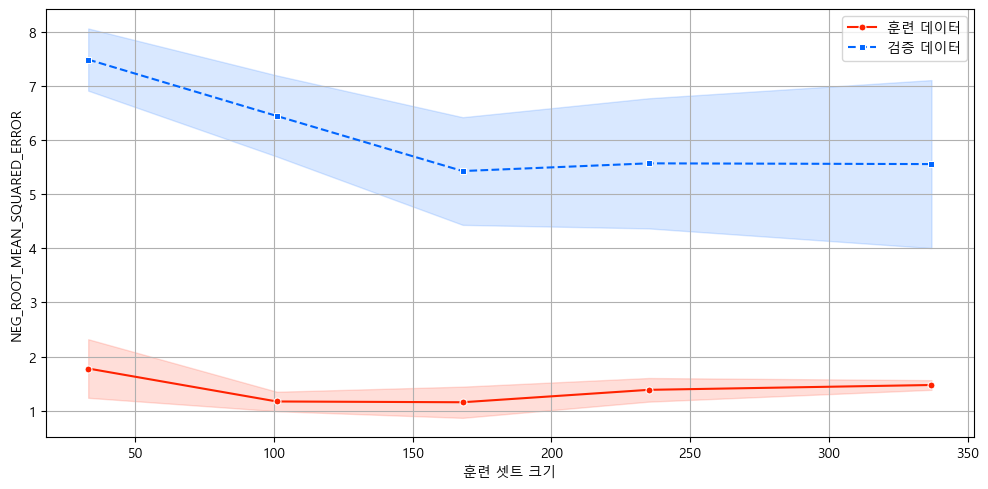

CPU times: total: 156 ms
Wall time: 28.6 s


In [15]:
%%time
my_regression_result(
    estimator=estimator, x_train=x_train2, y_train=y_train2, x_test=x_test2, y_test=y_test2
)

In [16]:
%%time
my_regression_report(
    estimator=estimator, x_train=x_train2, y_train=y_train2, x_test=x_test2, y_test=y_test2
)

+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV       | INDUS      |  4.9238 |
|  3 | MEDV       | CHAS       | 1.32047 |
|  4 | MEDV       | NOX        | 4.17384 |
|  5 | MEDV       | RM         | 1.82706 |
|  6 | MEDV       | AGE        | 2.93317 |
|  7 | MEDV       | DIS        | 4.41185 |
|  8 | MEDV       | RAD        | 9.98804 |
|  9 | MEDV       | TAX        | 10.5503 |
| 10 | MEDV       | PTRATIO    | 1.88398 |
| 11 | MEDV       | B          |  1.5563 |
| 12 | MEDV       | LSTAT      |  2.8052 |
+----+------------+------------+---------+

CPU times: total: 15.6 ms
Wall time: 15 ms


[교차검증 TOP5]
+----+----------------+----------------+-------------+----------------+-------------------+
|    |   n_estimators | max_features   |   max_depth | criterion      |   mean_test_score |
|----+----------------+----------------+-------------+----------------+-------------------|
|  0 |             50 | log2           |          50 | friedman_mse   |          0.882938 |
|  1 |            100 | log2           |          10 | squared_error  |          0.879718 |
|  2 |            100 | sqrt           |          50 | absolute_error |          0.875785 |
|  3 |            100 | log2           |         nan | poisson        |          0.874856 |
|  4 |             20 | sqrt           |          20 | friedman_mse   |          0.872629 |
+----+----------------+----------------+-------------+----------------+-------------------+

[Best Params]
{'n_estimators': 50, 'max_features': 'log2', 'max_depth': 50, 'criterion': 'friedman_mse'}

[회귀분석 성능평가]
+-------------------------------+--------

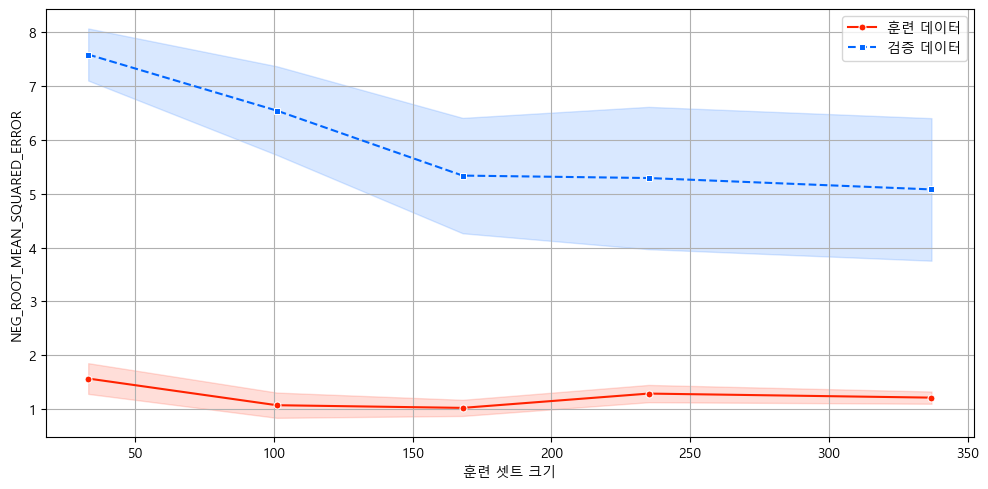


+----+------------+------------+---------+
|    | 종속변수   | 독립변수   |     VIF |
|----+------------+------------+---------|
|  0 | MEDV       | CRIM       | 2.09518 |
|  1 | MEDV       | ZN         | 2.33731 |
|  2 | MEDV       | INDUS      |  4.9238 |
|  3 | MEDV       | CHAS       | 1.32047 |
|  4 | MEDV       | NOX        | 4.17384 |
|  5 | MEDV       | RM         | 1.82706 |
|  6 | MEDV       | AGE        | 2.93317 |
|  7 | MEDV       | DIS        | 4.41185 |
|  8 | MEDV       | RAD        | 9.98804 |
|  9 | MEDV       | TAX        | 10.5503 |
| 10 | MEDV       | PTRATIO    | 1.88398 |
| 11 | MEDV       | B          |  1.5563 |
| 12 | MEDV       | LSTAT      |  2.8052 |
+----+------------+------------+---------+

CPU times: total: 281 ms
Wall time: 1.86 s


RandomForestRegressor(criterion='friedman_mse', max_depth=50,
                      max_features='log2', n_estimators=50, n_jobs=-1,
                      random_state=0, verbose=False)

In [17]:
%%time
my_rf_regression(x_train=x_train2, y_train=y_train2, x_test=x_test2, y_test=y_test2)

In [18]:
support = YjkClassifierSupport()

사용 가능한 모델 : ['LogisticRegression', 'SGDClassifier', 'KNeighborsClassifier', 'LinearSVC', 'SVC', 'GaussianNB', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatboostClassifier']


In [19]:
result_df = yjk_classifier_multi_gridsearch(support, x_train, y_train, x_test, y_test)

LogisticRegression 모델 소요 시간 : 0:00:00
SGDClassifier 모델 소요 시간 : 0:00:00
KNeighborsClassifier 모델 소요 시간 : 0:00:00
LinearSVC 모델 소요 시간 : 0:00:00
SVC 모델 소요 시간 : 0:00:00
GaussianNB 모델 소요 시간 : 0:00:00
DecisionTreeClassifier 모델 소요 시간 : 0:00:00
RandomForestClassifier 모델 소요 시간 : 0:00:03
CatboostClassifier 모델 소요 시간 : 0:00:05
총 소요 시간 : 0:00:09


In [20]:
result_df

,best_model,best_param,accuracy_train,accuracy_test
model_name,,,,
SGDClassifier,"SGDClassifier(early_stopping=True, eta0=0.5, l...","{'tol': 0.0001, 'penalty': 'l1', 'max_iter': 2...",0.767101,0.811688
CatboostClassifier,<catboost.core.CatBoostClassifier object at 0x...,{},0.939739,0.811688
LogisticRegression,"LogisticRegression(C=0.1, n_jobs=-1)","{'penalty': 'l2', 'max_iter': 100, 'C': 0.1}",0.760586,0.805195
RandomForestClassifier,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'n_estimators': 500, 'min_samples_split': 2, ...",0.990228,0.805195
KNeighborsClassifier,"KNeighborsClassifier(n_jobs=-1, n_neighbors=7)","{'weights': 'uniform', 'p': 2, 'n_neighbors': 7}",0.788274,0.798701
LinearSVC,"LinearSVC(C=0.01, dual=False, penalty='l1', ra...","{'penalty': 'l1', 'max_iter': 1000, 'loss': 's...",0.763844,0.798701
SVC,"SVC(C=10, degree=4, kernel='linear')","{'kernel': 'linear', 'degree': 4, 'C': 10}",0.760586,0.798701
GaussianNB,GaussianNB(),{'var_smoothing': 1e-09},0.749186,0.785714
DecisionTreeClassifier,"DecisionTreeClassifier(criterion='entropy', ma...","{'splitter': 'random', 'min_samples_split': 2,...",0.794788,0.720779


In [21]:
support = YjkRegressorSupport()

사용 가능한 모델 : ['LinearRegressor', 'Ridge', 'Lasso', 'SGDRegressor', 'KneighborsRegressor', 'LinearSVR', 'SVR', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor']


In [22]:
result_df = yjk_regressor_multi_gridsearch(support, x_train2, y_train2, x_test2, y_test2)

LinearRegressor 모델 소요 시간 : 0:00:00
Ridge 모델 소요 시간 : 0:00:00
Lasso 모델 소요 시간 : 0:00:00
SGDRegressor 모델 소요 시간 : 0:00:00
KneighborsRegressor 모델 소요 시간 : 0:00:00
LinearSVR 모델 소요 시간 : 0:00:00
SVR 모델 소요 시간 : 0:00:00
DecisionTreeRegressor 모델 소요 시간 : 0:00:00
RandomForestRegressor 모델 소요 시간 : 0:00:01
CatBoostRegressor 모델 소요 시간 : 0:00:04
총 소요 시간 : 0:00:06


In [23]:
result_df

,best_model,best_param,rmse_train,rmse_test
model_name,,,,
CatBoostRegressor,<catboost.core.CatBoostRegressor object at 0x0...,{},0.449500,4.836556
SVR,"SVR(C=10, degree=4)","{'kernel': 'rbf', 'degree': 4, 'C': 10}",2.703572,5.089660
RandomForestRegressor,"(DecisionTreeRegressor(max_depth=30, max_featu...","{'min_samples_split': 2, 'min_samples_leaf': 1...",1.130934,5.236766
KneighborsRegressor,"KNeighborsRegressor(n_jobs=-1, n_neighbors=3, ...","{'weights': 'distance', 'p': 1, 'n_neighbors': 3}",0.000000,5.688329
LinearRegressor,LinearRegression(n_jobs=-1),{},4.396188,5.783509
LinearSVR,"LinearSVR(C=1, dual=True, loss='squared_epsilo...","{'max_iter': 1000, 'loss': 'squared_epsilon_in...",4.396315,5.788375
Lasso,Lasso(alpha=0.01),{'alpha': 0.01},4.396748,5.795788
SGDRegressor,"SGDRegressor(alpha=1, early_stopping=True, max...","{'tol': 0.0001, 'penalty': None, 'max_iter': 1...",4.454093,5.826158
Ridge,Ridge(alpha=10),{'alpha': 10},4.405748,5.853897
